## Data Loading and Inspection

In [1]:
import pandas as pd
import numpy as np

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Load dataset
df = pd.read_csv("D:/WORKSPACE_CS/LJMU_Research/other/dash/health_policy_recomendation/src/health_policy_recomendation/data/ushealthinsurance_with_company3.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1338 non-null   int64  
 1   sex                1338 non-null   object 
 2   bmi                1338 non-null   float64
 3   children           1338 non-null   int64  
 4   smoker             1338 non-null   object 
 5   region             1338 non-null   object 
 6   charges            1338 non-null   float64
 7   insurance_company  1338 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 83.8+ KB


In [12]:
df.head()

,age,sex,bmi,children,smoker,region,charges,insurance_company
0,19,female,27.900,0,yes,southwest,16884.92400,Company C
1,18,male,33.770,1,no,southeast,1725.55230,Company D
2,28,male,33.000,3,no,southeast,4449.46200,Company D
3,33,male,22.705,0,no,northwest,21984.47061,Company C
4,32,male,28.880,0,no,northwest,3866.85520,Company D


In [13]:
df['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [14]:
df['insurance_company'].value_counts(normalize=True)

insurance_company
Company D    0.415546
Company A    0.336323
Company C    0.132287
Company B    0.115845
Name: proportion, dtype: float64

## Feature Engineering

In [15]:
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)

df['budget'] = pd.cut(
    df['charges'],
    bins=[-float('inf'), q1, q3, float('inf')],
    labels=['low', 'medium', 'high']
)

df['budget'] = df['budget'].astype('object')

In [16]:
def feedback_score(row):
    # budget_score = row['budget'].map({'low': 5, 'medium': 3, 'high': 1})

    # score = (
    #     budget_score + 
    #     row['smoker'].map({'yes': -1, 'no': 1}) + 
    #     row['bmi'].apply(lambda x: 1 if x < 25 else -1)
    # )

    # return score.clip(0, 5)

    budget_score = {'low': 5, 'medium': 3, 'high': 1}.get(row['budget'], 0)
    smoker_score = {'yes': -1, 'no': 1}.get(row['smoker'], 0)
    bmi_score = 1 if row['bmi'] < 25 else -1

    score = budget_score + smoker_score + bmi_score

    # Clip the score between 0 and 5
    return max(0, min(5, score))


df['feedback'] = df.apply(feedback_score, axis=1)

In [17]:
def health_score(row):
    score = 2
    if row['bmi'] < 25:
        score += 1
    elif row['bmi'] >= 30:
        score -= 1

    score += 1 if row['smoker'] == 'no' else -1
    return score

df['health_score'] = df.apply(health_score, axis=1)

health score (from BMI + smoker)  
```
BMI | Smoker | Final Score
≥30 | Yes | 0
25–29.9 | No | 3
<25 | No | 4
```

'age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'budget', 'feedback', 'health_score'

In [18]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'insurance_company', 'budget', 'feedback', 'health_score'],
      dtype='object')

## EDA

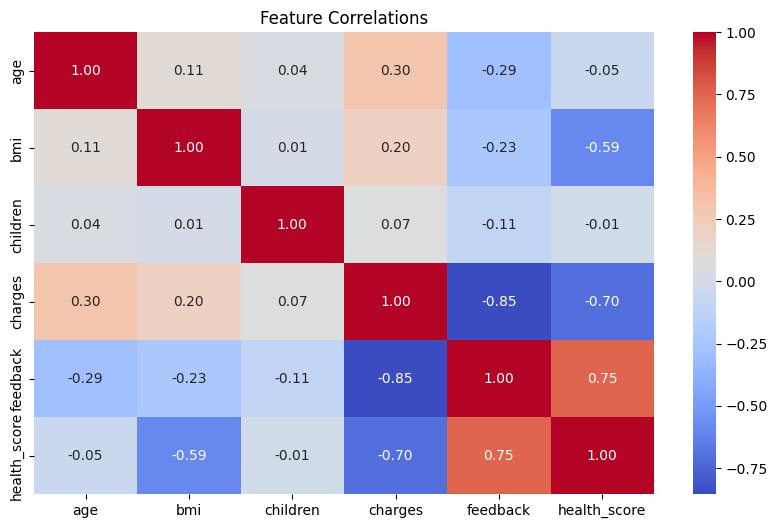

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.show()

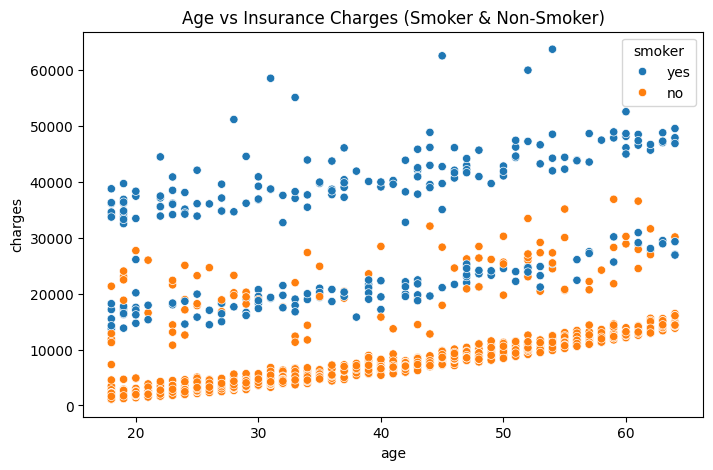

In [20]:
# Age vs Charges

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["age"], y=df["charges"], hue=df["smoker"])
plt.title("Age vs Insurance Charges (Smoker & Non-Smoker)")
plt.show()

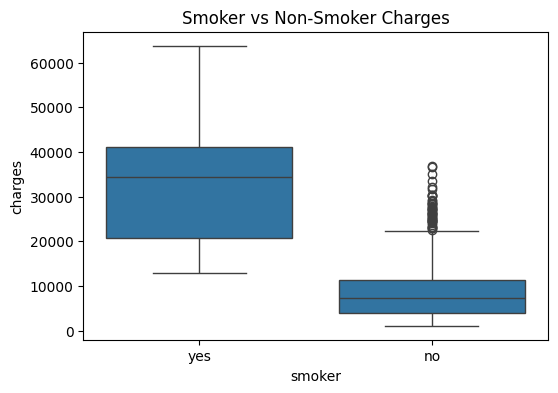

In [21]:
# Smoker Impact on Charges

plt.figure(figsize=(6, 4))
sns.boxplot(x=df["smoker"], y=df["charges"])
plt.title("Smoker vs Non-Smoker Charges")
plt.show()

## Approach 1: Content based recomendation system

In [22]:
aggregations = {
    'budget': lambda x: x.mode()[0] if not x.mode().empty else None, # Most frequent budget category
    'feedback': 'mean',           # Average feedback score
    'health_score': 'mean',       # Average health score of customers the company targets 
    'region': lambda x: x.mode()[0] # company region
}

In [23]:
company_df = df[['insurance_company', 'budget','region', 'health_score', 'feedback']].groupby('insurance_company').agg(aggregations)
company_df.rename(columns={'budget':'company_cost_tier', 'feedback': 'company_avg_feedback', 'health_score': 'clients_avg_health_score', 'region': 'company_region'}, inplace=True)
company_df

,company_cost_tier,company_avg_feedback,clients_avg_health_score,company_region
insurance_company,,,,
Company A,medium,3.262222,2.542222,northeast
Company B,high,0.045161,0.129032,southeast
Company C,high,0.757062,1.864407,southeast
Company D,low,4.338129,2.715827,southeast


In [24]:
user_df = df[['insurance_company', 'budget','region', 'health_score', 'feedback']]
user_df.rename(columns={'budget':'user_budget', 'feedback': 'user_feedback', 'health_score': 'user_health_score', 'region': 'user_region'}, inplace=True)

In [25]:
user_df.head()

,insurance_company,user_budget,user_region,user_health_score,user_feedback
0,Company C,high,southwest,1,0
1,Company D,low,southeast,2,5
2,Company D,low,southeast,2,5
3,Company C,high,northwest,4,3
4,Company D,low,northwest,3,5


In [26]:
print(list(user_df.columns))
print(list(company_df.columns))

['insurance_company', 'user_budget', 'user_region', 'user_health_score', 'user_feedback']
['company_cost_tier', 'company_avg_feedback', 'clients_avg_health_score', 'company_region']


In [27]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 1. Define ALL possible categories explicitly
all_budgets = user_df['user_budget'].unique().tolist()
all_regions = user_df['user_region'].unique().tolist() # Ensure this is complete

# 2. Initialize ONE encoder with these categories
encoder = OneHotEncoder(categories=[all_budgets, all_regions],
                        sparse_output=False,
                        handle_unknown='ignore') # Important!

# 3. Fit and Transform COMPANY data's categorical columns
# Note: Column names must match what the encoder expects based on categories order
user_cats_to_encode = user_df[['user_budget', 'user_region']]
encoded_user_cats = encoder.fit_transform(user_cats_to_encode)
expected_input_names = encoder.feature_names_in_

encoded_user_col_names = encoder.get_feature_names_out(expected_input_names) # Get consistent names
encoded_user_cats_df = pd.DataFrame(encoded_user_cats, columns=encoded_user_col_names, index=user_df.index)


# 4. Transform NEW USER data's categorical columns
#    a. Create a DataFrame for the user with columns matching what the encoder was fitted on
# user_cats_to_encode = pd.DataFrame({
#     'company_cost_tier': [new_user_input['user_budget']], # Use the key expected by the encoder
#     'company_region': [new_user_input['user_region']]      # Use the key expected by the encoder
# })
company_cats_to_encode = company_df[['company_cost_tier', 'company_region']].rename(columns={'company_cost_tier': 'user_budget', 'company_region': 'user_region'}) # Rename to match the encoder's expected input names
#    b. Use the SAME fitted encoder to TRANSFORM the user data
encoded_company_cats = encoder.transform(company_cats_to_encode)
encoded_company_cats_df = pd.DataFrame(encoded_company_cats, columns=encoded_user_col_names, index=company_df.index) # Use same column names

# 5. Scale Numerical Data

# For Company: (Do this when creating the final vector)
scaled_company_health = company_df['clients_avg_health_score'] / 4.0
scaled_company_feedback = company_df['company_avg_feedback'] / 5.0

# For User: (Do this when creating the final vector)
scaled_user_health = user_df['user_health_score'] / 4.0
sclaled_user_feedback = user_df['user_feedback'] / 5.0

In [28]:
print(company_df.columns.to_list())
print(user_df.columns.to_list())

['company_cost_tier', 'company_avg_feedback', 'clients_avg_health_score', 'company_region']
['insurance_company', 'user_budget', 'user_region', 'user_health_score', 'user_feedback']


In [29]:
# Use pandas.concat to join columns (axis=1)
# This works because both DataFrames should have the same index (company names)
company_vectors = pd.concat([encoded_company_cats_df, scaled_company_health, scaled_company_feedback], axis=1)
user_vectors = pd.concat([encoded_user_cats_df, scaled_user_health, sclaled_user_feedback], axis=1)

In [30]:
company_vectors

,user_budget_high,user_budget_low,user_budget_medium,user_region_southwest,user_region_southeast,user_region_northwest,user_region_northeast,clients_avg_health_score,company_avg_feedback
insurance_company,,,,,,,,,
Company A,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.635556,0.652444
Company B,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.032258,0.009032
Company C,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.466102,0.151412
Company D,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.678957,0.867626


In [31]:
user_vectors.head()

,user_budget_high,user_budget_low,user_budget_medium,user_region_southwest,user_region_southeast,user_region_northwest,user_region_northeast,user_health_score,user_feedback
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.25,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.50,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.50,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,0.6
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.75,1.0


In [32]:
company_vectors.values.shape

(4, 9)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert to NumPy arrays
company_vectors_np = company_vectors.values
user_vector_np = user_vectors.values # Shape will be (1, num_features)

print(f"User vector shape (NumPy): {user_vector_np.shape}")
print(f"Company vectors shape (NumPy): {company_vectors_np.shape}")

User vector shape (NumPy): (1338, 9)
Company vectors shape (NumPy): (4, 9)


In [26]:
# 2. Calculate Cosine Similarity
#    Calculates similarity between the user vector and EACH company vector
similarities = cosine_similarity(user_vector_np, company_vectors_np)

# The result 'similarities' is a 2D array, shape (1, num_companies).
# We need the first (and only) row.
similarity_scores_array = similarities[0]
print("\nRaw similarity scores:", similarity_scores_array)


Raw similarity scores: [0.06577077 0.49619747 0.51943417 0.06592933]


In [27]:
similarities.shape

(1338, 4)

In [28]:
# 3. Map scores back to company names for readability
#    Use the index from the company_vectors DataFrame
similarity_scores = pd.Series(similarity_scores_array, index=company_vectors.index)

In [29]:
# 4. Display ranked results
print("\n--- Similarity Scores (Ranked) ---")
print(similarity_scores.sort_values(ascending=False))


--- Similarity Scores (Ranked) ---
insurance_company
Company C    0.519434
Company B    0.496197
Company D    0.065929
Company A    0.065771
dtype: float64


In [30]:
# 5. Get the top recommendation
recommendation = similarity_scores.idxmax() # Get the index (company name) of the max score
highest_score = similarity_scores.max()

print(f"\n--- Recommendation ---")
print(f"The recommended insurance company is: {recommendation} (Similarity Score: {highest_score:.4f})")


--- Recommendation ---
The recommended insurance company is: Company C (Similarity Score: 0.5194)


In [64]:
import joblib

joblib.dump(encoder, r'D:\WORKSPACE_CS\LJMU_Research\other\dash\health_policy_recomendation\src\health_policy_recomendation\models\content_based\region_budget_encoder.pkl')

company_vectors.to_csv(f'D:\WORKSPACE_CS\LJMU_Research\other\dash\health_policy_recomendation\src\health_policy_recomendation\models\content_based\company_vectors.csv', index=True)

#### Let's test recommendation

In [38]:
df.iloc[0]

age                         19
sex                     female
bmi                       27.9
children                     0
smoker                     yes
region               southwest
charges              16884.924
insurance_company    Company C
budget                    high
feedback                     0
health_score                 1
Name: 0, dtype: object

## Recommendation pipeline

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

def feedback_score(row):
    # budget_score = row['user_budget'].map({'low': 5, 'medium': 3, 'high': 1})

    # score = (
    #     budget_score + 
    #     row['smoker'].map({'yes': -1, 'no': 1}) + 
    #     row['bmi'].apply(lambda x: 1 if x < 25 else -1)
    # )

    # return score.clip(0, 5)

    budget_score = {'low': 5, 'medium': 3, 'high': 1}.get(row['user_budget'], 0)
    smoker_score = {'yes': -1, 'no': 1}.get(row['smoker'], 0)
    bmi_score = 1 if row['bmi'] < 25 else -1

    score = budget_score + smoker_score + bmi_score

    # Clip the score between 0 and 5
    return max(0, min(5, score))


def health_score(row):
    score = 2
    if row['bmi'] < 25:
        score += 1
    elif row['bmi'] >= 30:
        score -= 1

    score += 1 if row['smoker'] == 'no' else -1
    return score

def create_user_vector(new_user_input: dict, encoder: OneHotEncoder) -> np.ndarray:
    user_input_df = pd.DataFrame([new_user_input])
    user_input_df['user_health_score'] = user_input_df.apply(health_score, axis=1)

    if 'user_feedback' not in user_input_df.columns:
        user_input_df['user_feedback'] = user_input_df.apply(feedback_score, axis=1)

    # Encode categorical features
    encoded_cats = encoder.transform(user_input_df[['user_budget', 'user_region']])

    # Scale numerical features
    scaled_health = user_input_df['user_health_score'] / 4.0
    scaled_feedback = user_input_df['user_feedback'] / 5.0

    # Concatenate encoded and scaled features
    user_vector = np.hstack((encoded_cats, scaled_health.values.reshape(-1, 1), scaled_feedback.values.reshape(-1, 1)))
    
    return user_vector

def recomend(new_user_input, company_vectors, label_encoder):
    # create user vector
    user_vector = create_user_vector(new_user_input, label_encoder)

    # Calculate cosine similarity
    similarities = cosine_similarity(user_vector, company_vectors.values)
    
    # Map scores back to company names for readability
    similarity_scores = pd.Series(similarities[0], index=company_vectors.index)

    # # Get the top recommendation
    # recommendation = similarity_scores.idxmax() # Get the index (company name) of the max score
    # highest_score = similarity_scores.max()

    # return recommendation, highest_score

    # Display ranked top 3 recommendations
    recommendation = similarity_scores.sort_values(ascending=False).iloc[:3]
    return recommendation.to_dict()

In [11]:
import joblib

label_encoder = joblib.load(r"D:\1_New\LJMU_Thesis Submission_15 may 2025\Git_Repository\insurance-recomendation\src\health_policy_recommendation\models\content_based\region_budget_encoder.pkl")
company_vectors = pd.read_csv(r"D:\1_New\LJMU_Thesis Submission_15 may 2025\Git_Repository\insurance-recomendation\src\health_policy_recommendation\models\content_based\company_vectors.csv", index_col=0)

new_user_input = {
    'user_budget': 'high',        # Prefers low cost
    'user_region': 'southwest',  # Is in the southeast region
    'bmi': 27.9,            # Has a BMI of 22.0
    'smoker': 'yes',            # Is a non-smoker
    'user_feedback': 4.0,     # Has a feedback score of 4.0 (on a 0-5 scale) [Optional]
}

In [13]:
recomend(new_user_input, company_vectors, label_encoder)

{'Company C': 0.5030090031256507,
 'Company B': 0.436586793305203,
 'Company D': 0.293118951939263}


##  Evaluation metrics



In [ ]:
#1. Common Metric Functions
#Add these helper functions once at the top:

In [14]:
import numpy as np
import pandas as pd
import heapq

def precision_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    return len(set(recommended_k) & set(relevant_items)) / k

def recall_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    return len(set(recommended_k) & set(relevant_items)) / len(relevant_items) if relevant_items else 0

def hit_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    return 1 if set(recommended_k) & set(relevant_items) else 0

def ndcg_at_k(recommended_items, relevant_items, k):
    dcg = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            dcg += 1 / np.log2(i + 2)
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant_items), k))])
    return dcg / idcg if idcg > 0 else 0

def rmse(predicted_scores, true_scores):
    return np.sqrt(np.mean((np.array(predicted_scores) - np.array(true_scores)) ** 2))


In [ ]:
#2. Evaluate Each Method
#Below is how to apply these metrics to each recommendation output.

In [15]:
def evaluate_content_based(similarity_scores, ground_truth, k=5):
    recommended_items = [item for item, _ in sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)]
    return {
        'Precision@K': precision_at_k(recommended_items, ground_truth, k),
        'Recall@K': recall_at_k(recommended_items, ground_truth, k),
        'Hit@K': hit_at_k(recommended_items, ground_truth, k),
        'NDCG@K': ndcg_at_k(recommended_items, ground_truth, k)
    }


## XAI

In [62]:
import shap
import numpy as np
import pandas as pd

# Define a simplified wrapper around the recommender
def similarity_predictor(X_input):
    """
    X_input: np.ndarray of shape (n_samples, n_features) representing user vectors
    Returns: array of max similarity scores (or scores for a particular company)
    """
    return cosine_similarity(X_input, company_vectors.values).max(axis=1)

In [63]:
# Create a sample of user vectors to use as SHAP background data
background_users = user_vectors.sample(50, random_state=42).values


In [64]:
# New user input
new_user_input = {
    'user_budget': 'high',
    'user_region': 'southwest',
    'bmi': 27.9,
    'smoker': 'yes',
    'user_feedback': 4.0,
}

# Create user vector
user_vector = create_user_vector(new_user_input, label_encoder)

# Create explainer
explainer = shap.KernelExplainer(similarity_predictor, background_users)

# Get SHAP values for this prediction
shap_values = explainer.shap_values(user_vector)

# Convert to pandas for better interpretation
feature_names = list(encoded_user_col_names) + ['user_health_score_scaled', 'user_feedback_scaled']
shap_df = pd.DataFrame(shap_values, columns=feature_names)

# Print top contributing features
top_features = shap_df.abs().T.sort_values(by=0, ascending=False).head(5)
print("🔍 Top features contributing to the recommendation:")
print(top_features)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 26.97it/s]

🔍 Top features contributing to the recommendation:
                              0
user_region_southwest  0.090333
user_region_southeast  0.058744
user_budget_medium     0.047496
user_region_northwest  0.038938
user_budget_low        0.035356


In [65]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, feature_names=feature_names)


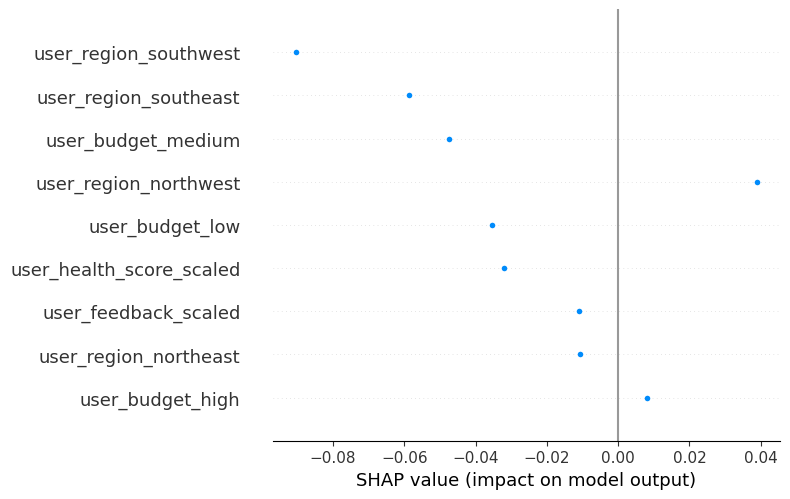

In [66]:
shap.summary_plot(shap_values, feature_names=feature_names)


In [39]:
# Prepare the force plot object
force_plot = shap.force_plot(explainer.expected_value, shap_values, features=user_vector, feature_names=feature_names)

# Save to HTML file
shap.save_html("shap_force_plot.html", force_plot)

In [41]:
# Create the SHAP force plot
force_plot = shap.force_plot(explainer.expected_value, shap_values[0], features=user_vector, feature_names=feature_names)

# Save it as a standalone HTML file with embedded JS
shap.save_html("shap_force_plot2.html", force_plot)

In [42]:
force_plot = shap.force_plot(explainer.expected_value, shap_values, features=user_vector, feature_names=feature_names)


In [43]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def fuse_recommendations(similarity_scores, feedback_scores, alpha=0.5):
    """
    Combine content-based similarity scores with utility-based feedback scores.

    Parameters:
        similarity_scores (dict): Dictionary of item_id -> similarity score (content-based).
        feedback_scores (dict): Dictionary of item_id -> predicted feedback/utility score (ML model).
        alpha (float): Weighting factor between 0 and 1. 
                       alpha = 1 uses only similarity, alpha = 0 uses only feedback.

    Returns:
        fused_scores (dict): Dictionary of item_id -> final fused score.
    """

    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame({
        'item_id': list(similarity_scores.keys()),
        'similarity': list(similarity_scores.values()),
        'feedback': [feedback_scores.get(i, 0) for i in similarity_scores.keys()]
    })

    # Normalize both scores to [0, 1] to ensure fair weighting
    scaler = MinMaxScaler()
    df[['similarity', 'feedback']] = scaler.fit_transform(df[['similarity', 'feedback']])

    # Apply fusion formula
    df['fused_score'] = alpha * df['similarity'] + (1 - alpha) * df['feedback']

    # Return as dictionary
    return dict(zip(df['item_id'], df['fused_score']))


In [44]:
# Example Usage
# Sample input (could come from two models)
similarity_scores = {'P1': 0.8, 'P2': 0.5, 'P3': 0.3}
feedback_scores = {'P1': 0.6, 'P2': 0.9, 'P3': 0.4}

# Try with alpha = 0.6 (more weight to content-based similarity)
fused = fuse_recommendations(similarity_scores, feedback_scores, alpha=0.6)

# Top recommendation
top_items = sorted(fused.items(), key=lambda x: x[1], reverse=True)
print(top_items)

[('P1', 0.76), ('P2', 0.64), ('P3', 0.0)]


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def fuse_recommendations(similarity_scores, feedback_scores, alpha=0.5):
    """
    Combine content-based similarity scores with utility-based ML predictions.

    Parameters:
        similarity_scores (dict): item_id -> content-based similarity score.
        feedback_scores (dict): item_id -> utility/feedback score from ML model.
        alpha (float): Balance between content-based and ML-based scores.
                       alpha=1: only content-based; alpha=0: only ML-based.

    Returns:
        fused_scores (dict): item_id -> combined fused score.
    """

    # Align the items present in both systems
    item_ids = list(set(similarity_scores) | set(feedback_scores))
    
    df = pd.DataFrame({
        'item_id': item_ids,
        'similarity_score': [similarity_scores.get(i, 0) for i in item_ids],
        'feedback_score': [feedback_scores.get(i, 0) for i in item_ids]
    })

    # # Normalize both scores to ensure fair fusion
    # scaler = MinMaxScaler()
    # df[['similarity_score', 'feedback_score']] = scaler.fit_transform(df[['similarity_score', 'feedback_score']])

    # Fuse scores using weighted average
    df['fused_score'] = alpha * df['similarity_score'] + (1 - alpha) * df['feedback_score']

    # Sort or filter if needed: 
    df = df.sort_values(by='fused_score', ascending=False)[:3]

    return dict(zip(df['item_id'], df['fused_score']))


In [24]:
# Example Usage
# Sample input (could come from two models)
similarity_scores = {'P1': 0.8, 'P2': 0.7, 'P3': 0.3}
feedback_scores = {'P1': 0.6, 'P2': 0.9, 'P4': 0.4}

# Try with alpha = 0.6 (more weight to content-based similarity)
fused = fuse_recommendations(similarity_scores, feedback_scores, alpha=0.6)

fused
# # Top recommendation
# top_items = sorted(fused.items(), key=lambda x: x[1], reverse=True)
# print(top_items)

{'P2': 0.78, 'P1': 0.72, 'P3': 0.18}